# Fundamental Diagrams at Measurement Lines

This notebook demonstrates how to calculate density, speed and flow of pedestrian trajectories at a measurement line.

All calculations are based on a Voronoi decomposition of the available space. The approach presented is an adaptation of the method for calculating the Voronoi density within a measurement area.
In order to define the contribution of an individual pedestrian to the calculation on the measurement line, the proportion of the measurement line being intersected by the pedestrian's Voronoi cell is determined. Here is an example of the speed calculation:

$$ v_{l} = \sum_i v_{i,n_{l}} * w_{i,l}$$ 

The speed at the measurement line ($v_{l}$) is calculated from the sum over the individual speed of pedestrians $i$ orthogonal to the measurement line ($v_{i,n_{l}}$) and their proportion of the line ($w_{i,l}$).
Density and flow are calculated in a similar way.

The method presented measures the flow perpendicular to a line, as in the classical physical definition of a flow. It is therefore particularly suitable for measuring directional flows, such as a uni- or bidirectional flow. For non-directional flows over a wide area, other measurement methods may be more suitable.

In the following, it is explained how to use pedpy to apply this approach.

## Analysis set-up

First, the trajectories must be loaded. This guide analyzes data from four corridor experiments. Two of the experiments have a unidirectional main movement direction, while the remaining two display a bidirectional main movement direction. The measurement line is aligned so that it is orthogonal to the main movement direction.

In [1]:
from pedpy import TrajectoryUnit

files = {
    "unidirectional 1": (
        "demo-data/uni-directional/traj_UNI_CORR_500_08.txt",
        TrajectoryUnit.METER,
    ),
    "unidirectional 2": (
        "demo-data/uni-directional/traj_UNI_CORR_500_03.txt",
        TrajectoryUnit.METER,
    ),
    "bidirectional 1": ("demo-data/bi-directional/bi_corr_400_b_08.txt", None),
    "bidirectional 2": ("demo-data/bi-directional/bi_corr_400_b_03.txt", None),
}

In [2]:
import pathlib

from pedpy import load_trajectory

trajectories = {}
for name, (path, unit) in files.items():
    trajectories[name] = load_trajectory(
        trajectory_file=pathlib.Path(path), default_unit=unit
    )

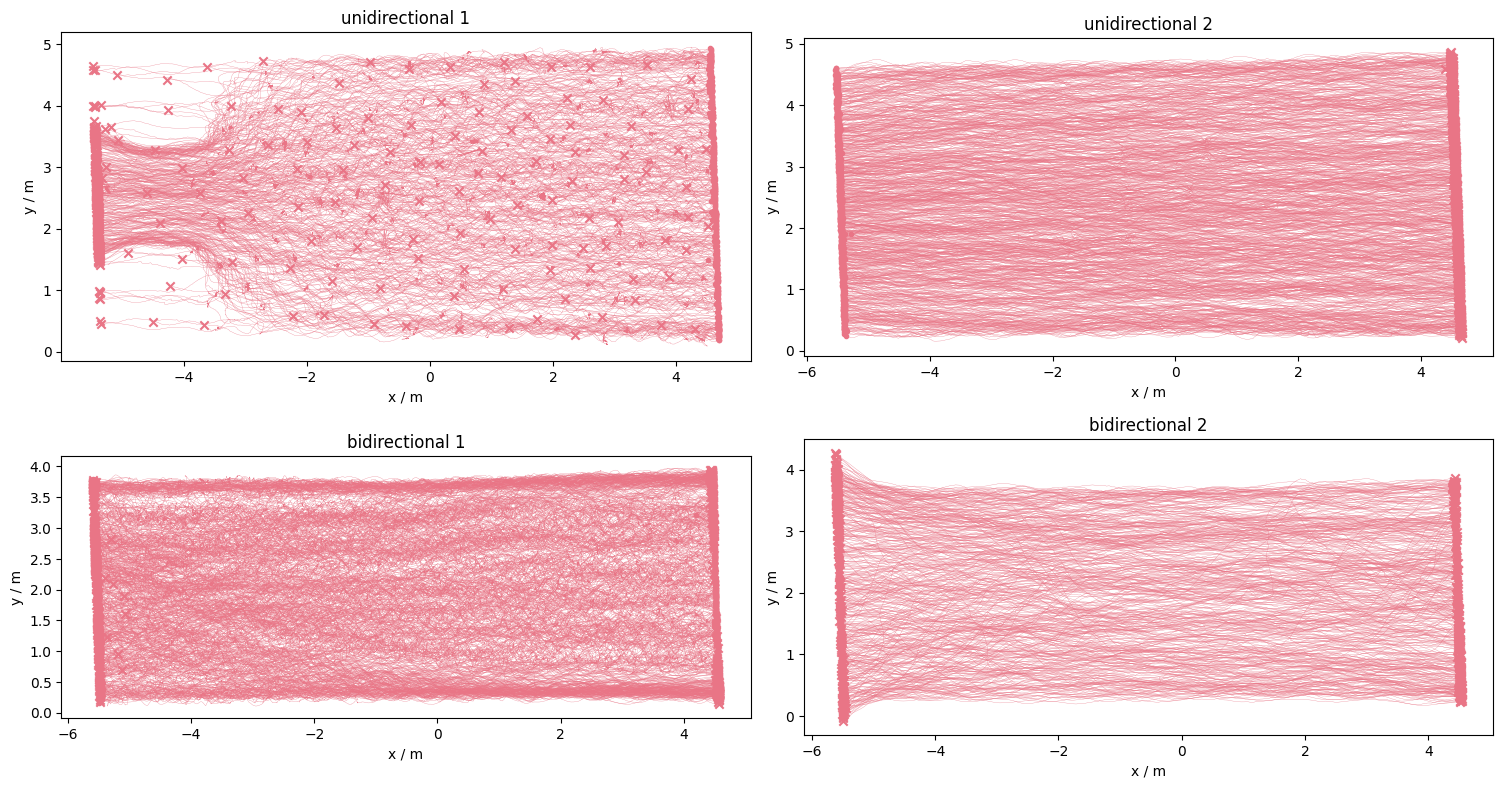

In [3]:
import matplotlib.pyplot as plt

from pedpy import plot_measurement_setup

fig, axs = plt.subplots(2, int(len(trajectories) / 2), figsize=(15, 8))

for (name, trajectory), ax in zip(
    trajectories.items(), axs.ravel(), strict=False
):
    ax.set_title(name)

    ax = plot_measurement_setup(
        traj=trajectory,
        axes=ax,
        traj_width=0.2,
        traj_start_marker=".",
        traj_end_marker="x",
        ma_color="g",
        ma_line_color="g",
        ma_alpha=0.2,
        ml_color="b",
    )
    ax.set_aspect("equal")

fig.tight_layout()
plt.show()

The plot above shows the trajectories of the experimental data analyzed in this Notebook. It consists of unidirectional and bidirectional experiments. One red line represents the trajectory of one pedestrian. Starting positions are marked with a dot and end positions are marked with an x.

Next the {class}`walkable area <geometry.WalkableArea>` of the experiment is defined.

In [4]:
from pedpy import WalkableArea

walkable_areas = {
    "unidirectional 1": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (6.5, -1.5), (6.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 5.0), (5.0, 5.0), (5.0, 6.0), (-6.0, 6.0)],
        ],
    ),
    "unidirectional 2": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (6.5, -1.5), (6.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 5.0), (5.0, 5.0), (5.0, 6.0), (-6.0, 6.0)],
        ],
    ),
    "bidirectional 1": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (5.5, -1.5), (5.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 4.0), (5.0, 4.0), (5.0, 5.0), (-6.0, 5.0)],
        ],
    ),
    "bidirectional 2": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (5.5, -1.5), (5.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-5.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-5.0, -1.0)],
            # upper Wall:
            [(-5.0, 4.1), (5.0, 4.1), (5.0, 5.0), (-5.0, 5.0)],
        ],
    ),
}

To obtain correct results, it is important that the measurement line is orthogonal to the main direction of movement.

In [5]:
from pedpy import MeasurementLine

measurement_lines = {
    "unidirectional 1": MeasurementLine([(0.0, 0.0), (0.0, 5.0)]),
    "unidirectional 2": MeasurementLine([(0.0, 0.0), (0.0, 5.0)]),
    "bidirectional 1": MeasurementLine([(0.0, 0.0), (0.0, 4.0)]),
    "bidirectional 2": MeasurementLine([(0.0, 0.0), (0.0, 4.0)]),
}

The entire setup, including trajectories, geometry, and measurement lines looks like this:

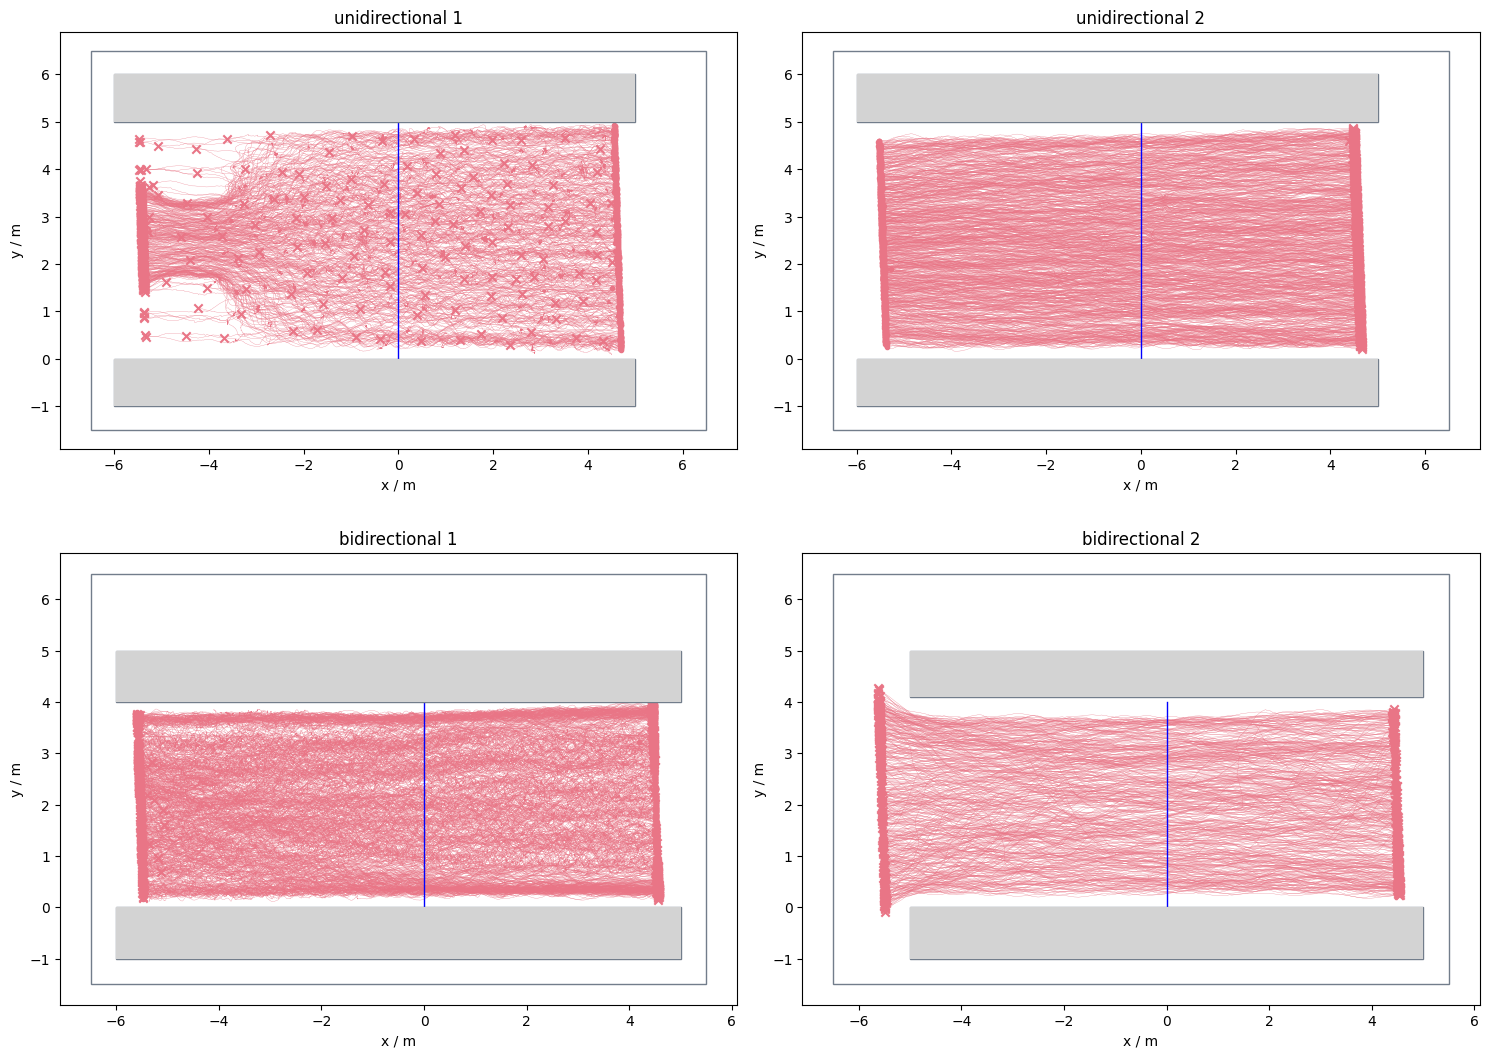

In [6]:
import matplotlib.pyplot as plt

from pedpy import plot_measurement_setup

fig, axs = plt.subplots(2, int(len(trajectories) / 2), figsize=(15, 11))

for (name, trajectory), ax in zip(
    trajectories.items(), axs.ravel(), strict=False
):
    ax.set_title(name)

    ax = plot_measurement_setup(
        traj=trajectory,
        walkable_area=walkable_areas[name],
        measurement_lines=[measurement_lines[name]],
        axes=ax,
        traj_width=0.2,
        traj_start_marker=".",
        traj_end_marker="x",
        ma_color="g",
        ma_line_color="g",
        ma_alpha=0.2,
        ml_color="b",
    )
    ax.set_aspect("equal")

fig.tight_layout()
plt.show()

## Calculate Voronoi polygons

The Voronoi decomposition is used to determine cells for each pedestrian and to calculate the density, speed and flow at a measurement line. It is highly recommended to use a cutoff when calculating the Voronoi polygons, as the resulting data can be inaccurate if individual pedestrians at the edge of a group have an impact on large areas, even if they are very far away.

Note that the calculation of the Voronoi polygons will take a while.

In [7]:
from pedpy.methods.method_utils import (
    Cutoff,
    compute_individual_voronoi_polygons,
)

individual_cutoffs = {}

In [8]:
individual_cutoffs["unidirectional 1"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["unidirectional 1"],
    walkable_area=walkable_areas["unidirectional 1"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [9]:
individual_cutoffs["unidirectional 2"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["unidirectional 2"],
    walkable_area=walkable_areas["unidirectional 2"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [10]:
individual_cutoffs["bidirectional 1"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["bidirectional 1"],
    walkable_area=walkable_areas["bidirectional 1"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [11]:
individual_cutoffs["bidirectional 2"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["bidirectional 2"],
    walkable_area=walkable_areas["bidirectional 2"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

## Determine the species

A species decribes a set of pedestrians that encouters the measurement line frome the same side. As there are two possible main directions of movement in which a line can be approached orthogonally, the pedestrians are divided into two species.
Here they are later referred to as Species 1 and 2. 

To decide to which species a pedestrian belongs to, the direction of their velocity at the first frame $t_{i,l}$ in which their Voronoi cell touches the line is determined.

To do so, a movement factor $m_i$ is defined for each pedestrian $i$ as the sign of the orthogonal velocity $n * v(t_{i,l})$ at $t_{i,l}$: 

$$ m_i = sign ( n * v(t_{i,l}) ) $$

$n$ is the normal vector of the measurement line and $v(t_{i,l})$ is the velocity of pedestrian $i$ when they reach the line $l$.

All pedestrians with $m_i=1$ have the same main movement direction and belong to Species 1, all pedestrian with $m_i=-1$ follow the opposite main movement direction and belong to Species 2. 

```{eval-rst}
.. figure:: ../docs/source/images/species_determination.svg
    :align: center
```
This image shows the frame when the decision as to which species the pedestrian belongs to is made.
It is the first frame in which their Voronoi cell intersects the line.
Now, the direction of the current velocity decides which species they are assigned to.

For the decision it is not relevant whether a pedestrian actually crosses the line afterward. 

In [12]:
from pedpy.methods.speed_calculator import compute_species

species = {}

for name in trajectories:
    species[name] = compute_species(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        trajectory_data=trajectories[name],
        frame_step=25,
    )

## Determine the individual speed

When calculating the individual velocity, make sure that the `compute velocity` option is used. 

Choosing the frame step is also important, as it determines how many frames before and after the current position are used for the calculation of the movement. 

If too many frames are selected, smaller movements may no longer be included in the overall image. 


When calculating the individual speed it might be necessary to specify the speed calculation for border cases. 
By default the Speed calculation is `BORDER_EXCLUDE` this excludes values at the edges of the trajectory data. 
If some values necessary for a later calculation are missing you will run into an error.      

It is possible to cut a few frames from the trajectory data used to determine the Voronoi polygons. 
If there are more frames at the beginning and end of the data used for the individual speed calculation than in the Voronoi decomposition, it is possible to solve the problem while keeping the same speed calculation.

You could also consider using a different speed calculation. 
The different calculation methods and further details how the individual speed is calculated are explained in the [user guide](user_guide).


In [13]:
from pedpy.methods.speed_calculator import (
    SpeedCalculation,
    compute_individual_speed,
)

calculation_methods = {
    "unidirectional 1": SpeedCalculation.BORDER_SINGLE_SIDED,
    "unidirectional 2": SpeedCalculation.BORDER_EXCLUDE,
    "bidirectional 1": SpeedCalculation.BORDER_EXCLUDE,
    "bidirectional 2": SpeedCalculation.BORDER_EXCLUDE,
}

individual_speeds = {}

for name in trajectories:
    individual_speeds[name] = compute_individual_speed(
        traj_data=trajectories[name],
        frame_step=1,
        compute_velocity=True,
        speed_calculation=calculation_methods[name],
    )

## Compute line speed

To determine the total speed perpendicular to the measuring line in a specific frame, all pedestrians whose Voronoi polygon intersect with the measuring line are taken into account.

```{eval-rst}
.. figure:: images/voronoi_at_line.svg
    :align: center
```

The speed of a single pedestrian results from the individual orthogonal speed multiplied by the share of the line. 


$$ v^{line}_i(t) = v_{i}(t) * n_{l} *  \frac{w_i(t)}{w} $$

Here $w_i(t)$ is the length of the part of the measurement line cut by the Voronoi cell, $w$ is the total length of the measurement line and $n_l$ is the vector normal to the line. 

```{eval-rst}
.. figure:: images/line_intersection_voronoi.svg
    :align: center
```

Due to the opposite main direction of movement of species 2, the sign of the velocities is also opposite. However, this leads to undesirable results when the contributions of the two species are added together, as the proportions of the species then cancel each other out. 
To correct the sign, the individual speeds are multiplied by the movement factor $m$ in the calculation.


The speed $v$ of a species $S$ can be calculated by the sum of all pedestrians of the species. 

$$ v^S(t) = \sum_{i} m * v^{line}_i(t)  \text{ with } i \epsilon S $$

The total speed combines the values of both species.


$$ v_{line}(t) = v^{\mathrm{I}}(t) + v^{\mathrm{II}}(t)$$ 

This approach was chosen to allow negative velocities within each species. These can occur when a person either stands still and wobbles their head or when they cross the line several times (i.e. in both directions). These cases should also be able to be measured with the method. 

In [14]:
from pedpy.methods.speed_calculator import compute_line_speed

speeds = {}
for name in trajectories:
    speeds[name] = compute_line_speed(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        individual_speed=individual_speeds[name],
        species=species[name],
    )

/Users/thochat/Desktop/Git-projects/PedPy-dev-fork/PedPy/pedpy/methods/method_utils.py:1192: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = species_1.merge(species_2, on=FRAME_COL, how="outer").fillna(0)
/Users/thochat/Desktop/Git-projects/PedPy-dev-fork/PedPy/pedpy/methods/method_utils.py:1192: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = species_1.merge(species_2, on=FRAME_COL, how="outer").fillna(0)


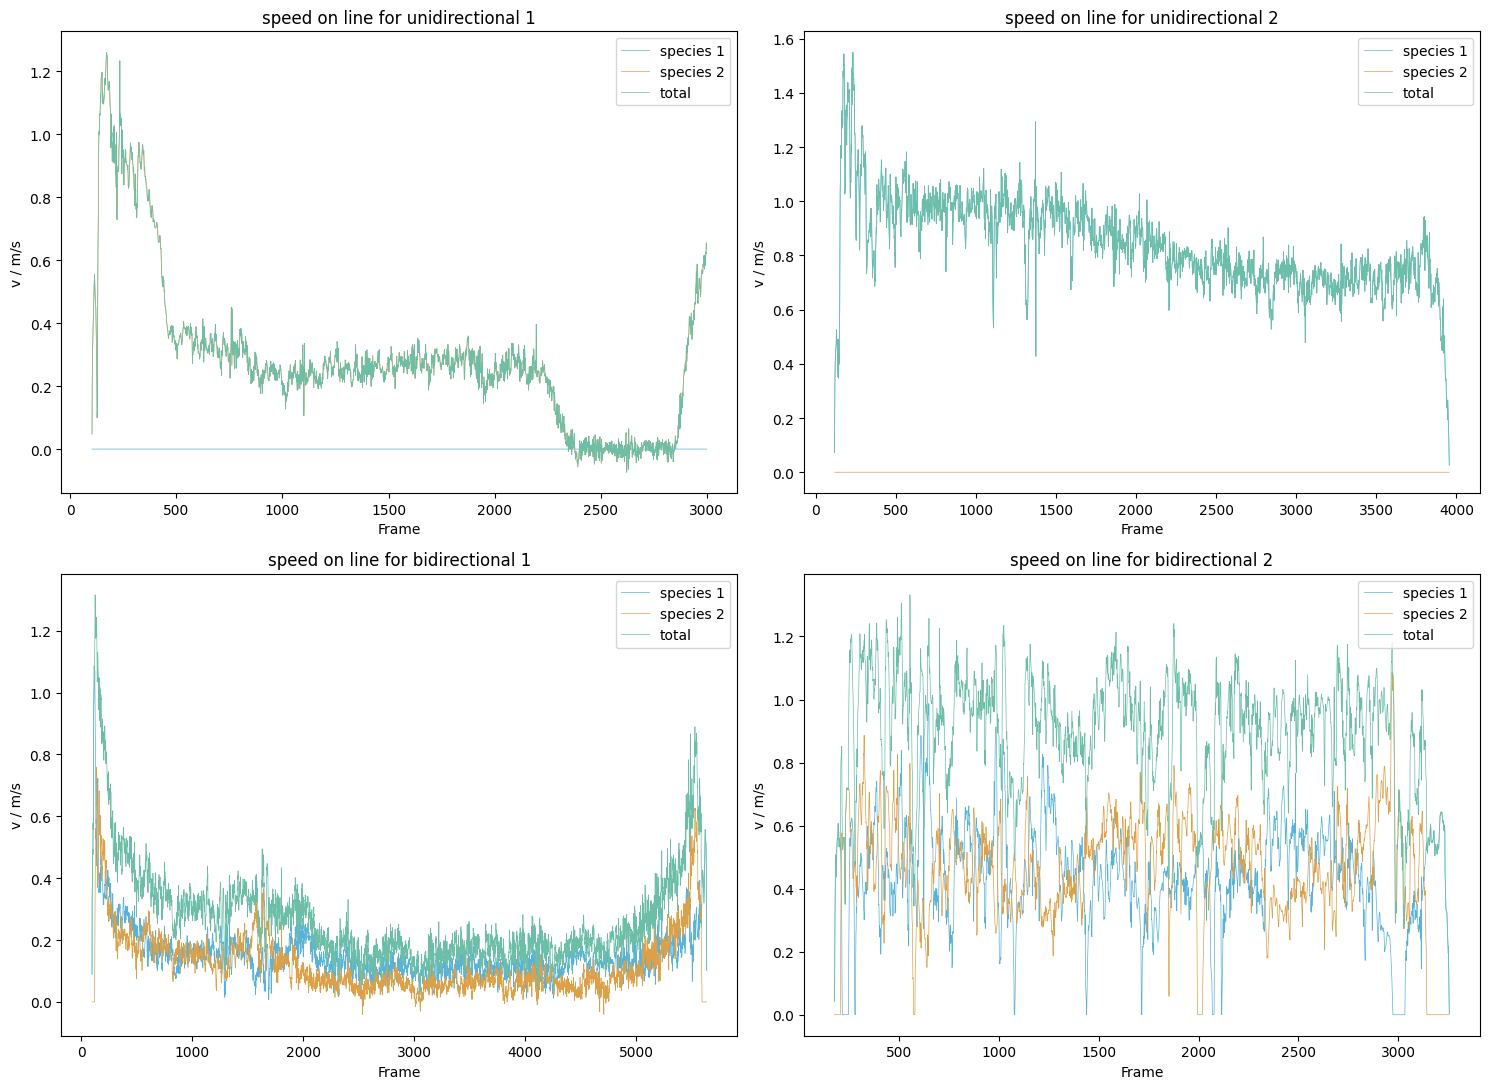

In [15]:
import matplotlib.pylab as plt

from pedpy.plotting.plotting import plot_speed_at_line

fig, axs = plt.subplots(2, int(len(speeds) / 2), figsize=(15, 11))

for (name, speed_on_line), ax in zip(speeds.items(), axs.ravel(), strict=False):
    ax = plot_speed_at_line(
        speed_at_line=speed_on_line,
        axes=ax,
        line_width=0.5,
        title="speed on line for " + name,
    )

fig.tight_layout()
plt.show()

## Compute line density

The density on the line is computed from the densities of a pedestrian Voronoi cell proportional to their share on the line.
The density of a species only considers the pedestrians representing the species.

$$ \rho^S(t) = \sum_{i} \frac{1}{A_i(t)} *  \frac{w_i(t)}{w}  \text{ with } i \epsilon S $$

$A_i(t)$ is the size of pedestrian $i$'s Voronoi cell.

$\frac{w_i(t)}{w}$ is again the fraction of the line that is intersected by the Voronoi cell of pedestrian i.

The total density combines the values of Species 1 and 2.

$$ \rho_{line}(t) = \rho^{\mathrm{I}}(t) + \rho^{\mathrm{II}}(t)$$ 

In [16]:
from pedpy.methods.density_calculator import compute_line_density

densities = {}
for name in trajectories:
    densities[name] = compute_line_density(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        species=species[name],
    )

/Users/thochat/Desktop/Git-projects/PedPy-dev-fork/PedPy/pedpy/methods/method_utils.py:1192: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = species_1.merge(species_2, on=FRAME_COL, how="outer").fillna(0)
/Users/thochat/Desktop/Git-projects/PedPy-dev-fork/PedPy/pedpy/methods/method_utils.py:1192: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = species_1.merge(species_2, on=FRAME_COL, how="outer").fillna(0)


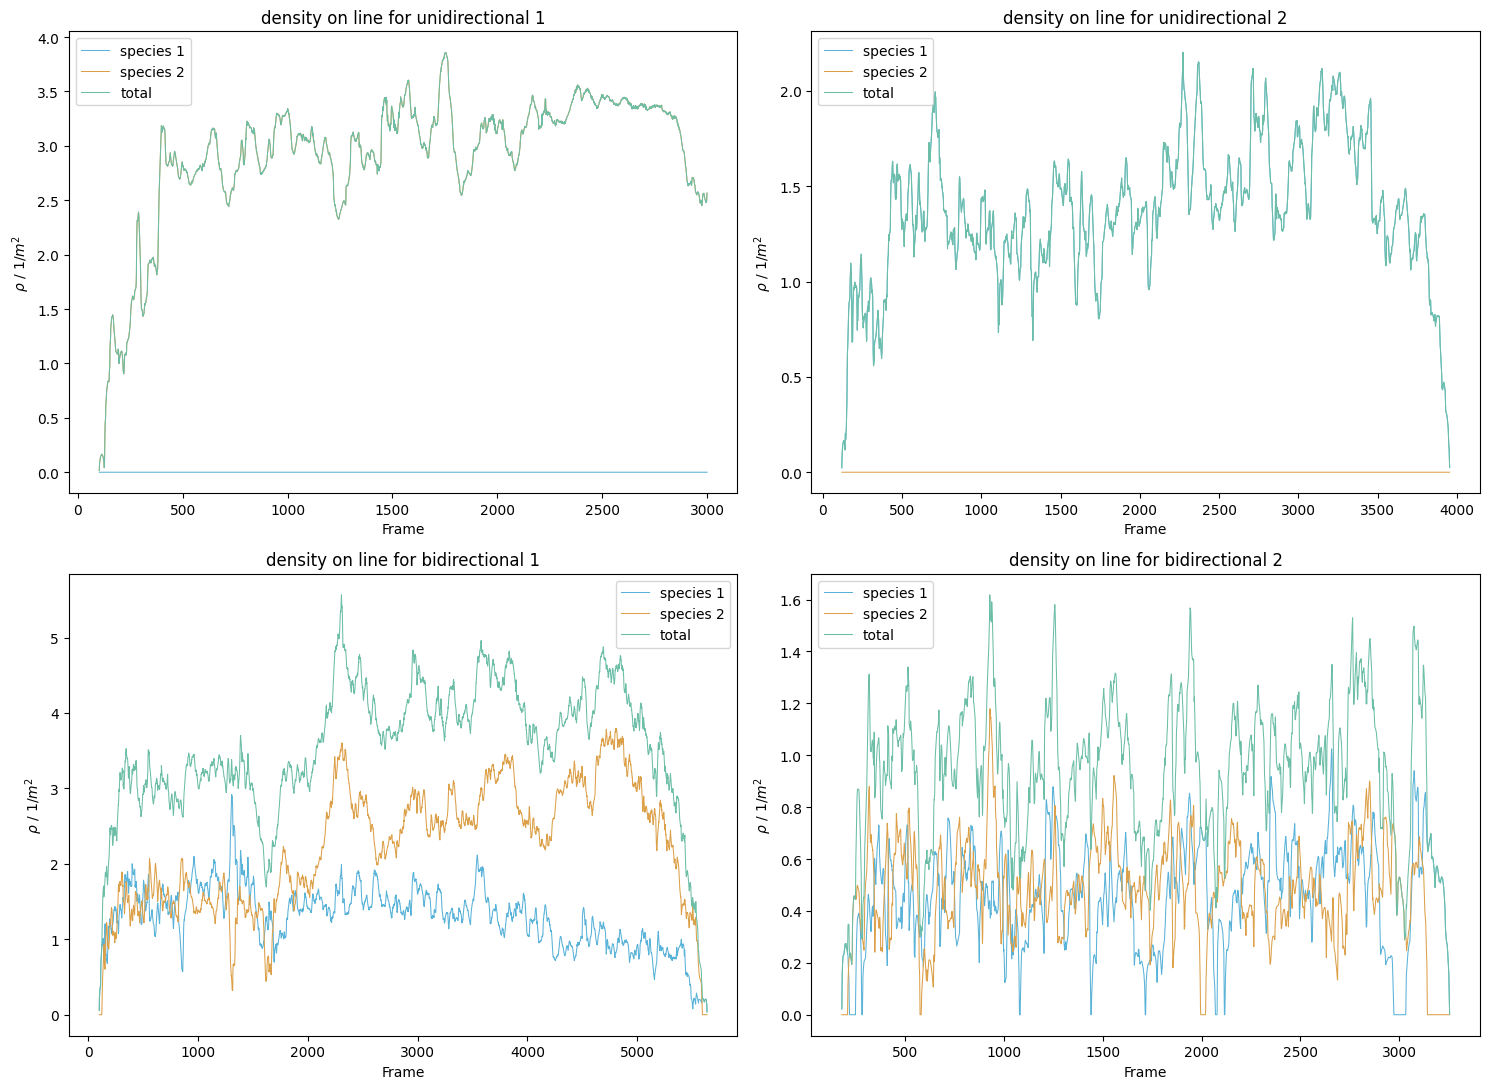

In [17]:
import matplotlib.pylab as plt

from pedpy.plotting.plotting import plot_density_at_line

fig, axs = plt.subplots(2, int(len(densities) / 2), figsize=(15, 11))

for (name, density_on_line), ax in zip(
    densities.items(), axs.ravel(), strict=False
):
    ax = plot_density_at_line(
        density_at_line=density_on_line,
        axes=ax,
        line_width=0.75,
        title="density on line for " + name,
    )

fig.tight_layout()
plt.show()

## Compute line flow

The calculation of the flow is derived from the flow equation $J = \rho v w$.


To compute the flow both the velocity orthogonal to the line and the density need to be considered.
Each species again only regards the pedestrians representing that species.
To remedy negative velocities orthogonal to the line of Species 2 the movement factor $m$ needs to be multiplied.

$$ j^S(t) = \sum_{i} m_i * v_i(t) * n_{l} * \frac{1}{A_i(t)} *  \frac{w_i(t)}{w}  \text{ with } i \epsilon S $$ 

To recap all the symbols of the equation: 

* $j$ is the flow
* $S$ is the species for which the flow is calculated
* $i$ is a pedestrian represented by $S$
* $m$ is the movement factor calculated while determining the species
* $v_i(t)$ is the velocity of pedestrian $i$
* $n_{l}$ is the orthogonal vector of line $l$
* $A_i(t)$ is the amount of space the Voronoi Cell of pedestrian $i$ takes up
* $w_i(t)$ is the length of the line intersecting with the Voronoi Cell of pedestrian $i$
* $w$ is the total length of the measurement line

the total flow combines the values of both species

$$ j_{line}(t) = j^{\mathrm{I}}(t) + j^{\mathrm{II}}(t) $$

In [18]:
from pedpy.methods.flow_calculator import compute_line_flow

flows = {}
for name in trajectories:
    flows[name] = compute_line_flow(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        species=species[name],
        individual_speed=individual_speeds[name],
    )

/Users/thochat/Desktop/Git-projects/PedPy-dev-fork/PedPy/pedpy/methods/method_utils.py:1192: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = species_1.merge(species_2, on=FRAME_COL, how="outer").fillna(0)
/Users/thochat/Desktop/Git-projects/PedPy-dev-fork/PedPy/pedpy/methods/method_utils.py:1192: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = species_1.merge(species_2, on=FRAME_COL, how="outer").fillna(0)


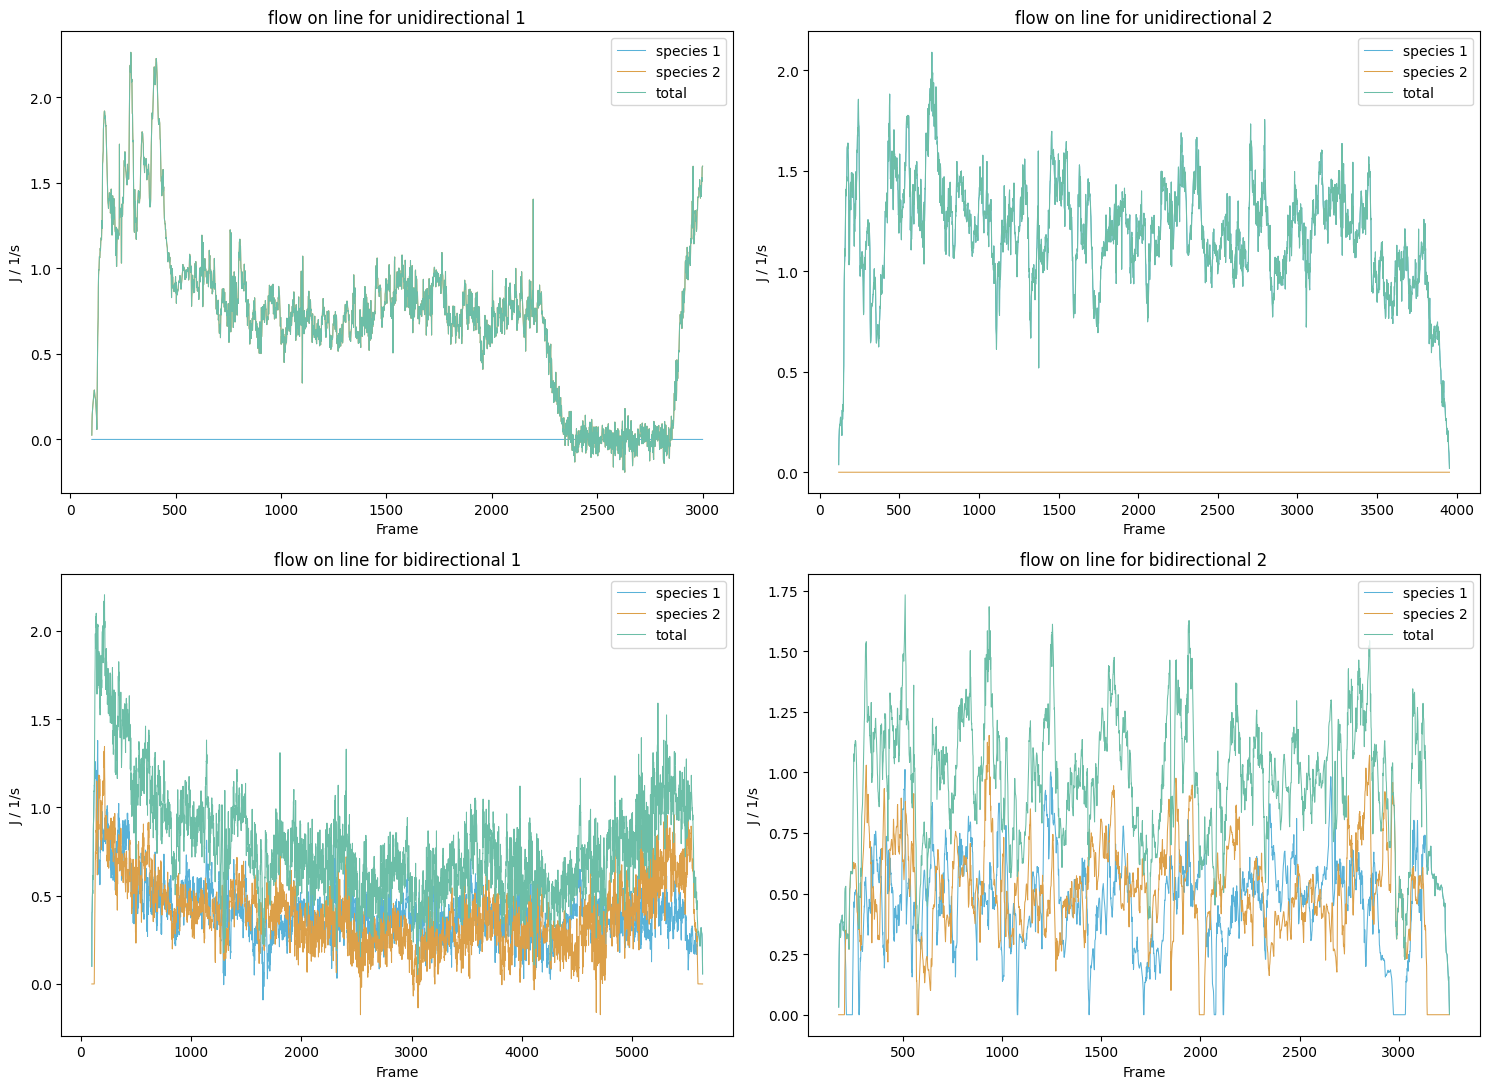

In [19]:
import matplotlib.pylab as plt

from pedpy.plotting.plotting import plot_flow_at_line

fig, axs = plt.subplots(2, int(len(flows) / 2), figsize=(15, 11))

for (name, flow_on_line), ax in zip(flows.items(), axs.ravel(), strict=False):
    ax = plot_flow_at_line(
        flow_at_line=flow_on_line,
        axes=ax,
        line_width=0.75,
        title="flow on line for " + name,
    )

fig.tight_layout()
plt.show()

## Excluding data from start and end phase

Upon closer examination of the trajectory data from the first unidirectional experiment, it becomes evident that not all the data collected are meaningful for analysis. This is due to the way the experiment was conducted. Toward the end of the experiment, participants were instructed to remain stationary. Consequently, although the data are technically usable, it may not contribute meaningfully to further analysis. When analyzing on your own it is recommended to exclude data that lack substantive relevance.

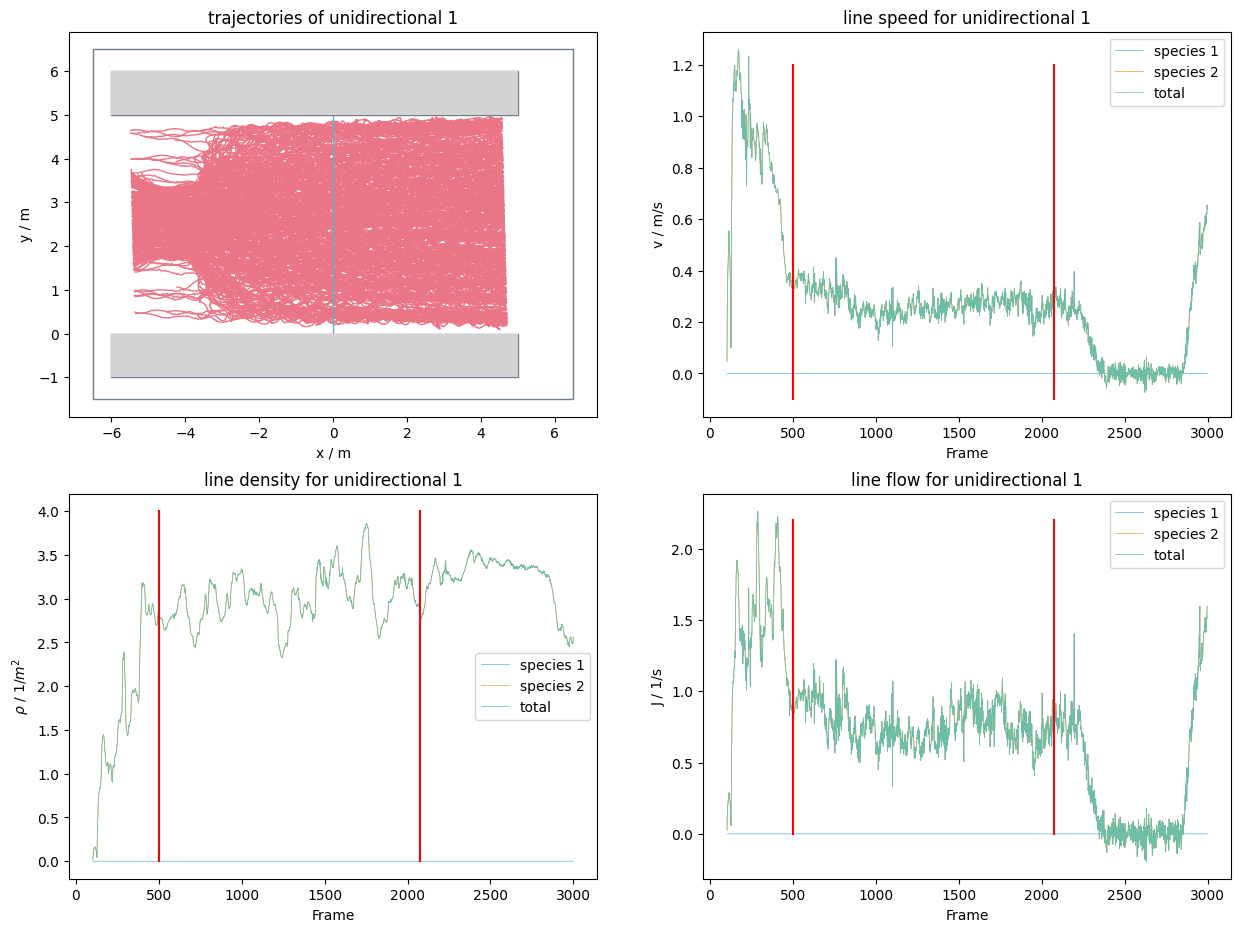

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(15, 11))

name = "unidirectional 1"

interval = [500, 2075]
plot_measurement_setup(
    axes=axs[0, 0],
    traj=trajectories[name],
    walkable_area=walkable_areas[name],
    measurement_lines=[measurement_lines[name]],
)
plot_speed_at_line(
    axes=axs[0, 1], speed_at_line=speeds[name], title=f"line speed for {name}"
)
axs[0, 1].plot([interval[0], interval[0]], [-0.1, 1.2], c="r")
axs[0, 1].plot([interval[1], interval[1]], [-0.1, 1.2], c="r")
plot_density_at_line(
    axes=axs[1, 0],
    density_at_line=densities[name],
    title=f"line density for {name}",
)
axs[1, 0].plot([interval[0], interval[0]], [0, 4], c="r")
axs[1, 0].plot([interval[1], interval[1]], [0, 4], c="r")
plot_flow_at_line(
    axes=axs[1, 1], flow_at_line=flows[name], title=f"line flow for {name}"
)
axs[1, 1].plot([interval[0], interval[0]], [0, 2.2], c="r")
axs[1, 1].plot([interval[1], interval[1]], [0, 2.2], c="r")


axs[0, 0].set_title(f"trajectories of {name}")
plt.show()

In the plots above you can see the trajectories of the first unidirectional experiment as well as the line speed, line density and line flow for said experiment. In between the red lines the measured values will be used for analysis. The additional data outside the red lines is removed for further analysis.

## Create a fundamental diagram

After completing the calculations it is possible to create a fundamental diagram.
Here we will use the precomputed data of 10 unidirectional and 10 bidirectional experiments all using the same experimental setup as previously. 


In [21]:
style_options = {
    "traj_UNI_CORR_500_01": {"color": "red", "marker": "+"},
    "traj_UNI_CORR_500_02": {"color": "green", "marker": "x"},
    "traj_UNI_CORR_500_03": {"color": "blue", "marker": "x"},
    "traj_UNI_CORR_500_04": {
        "color": "white",
        "marker": "s",
        "edgecolors": "pink",
    },
    "traj_UNI_CORR_500_05": {"color": "cyan", "marker": "s"},
    "traj_UNI_CORR_500_06": {"color": "grey", "marker": "^"},
    "traj_UNI_CORR_500_07": {
        "color": "white",
        "marker": "^",
        "edgecolors": "orange",
    },
    "traj_UNI_CORR_500_08": {"color": "black", "marker": "o"},
    "traj_UNI_CORR_500_09": {
        "color": "white",
        "marker": "o",
        "edgecolors": "purple",
    },
    "traj_UNI_CORR_500_10": {"color": "orange", "marker": "+"},
    "bi_corr_400_b_01": {"color": "red", "marker": "+"},
    "bi_corr_400_b_02": {"color": "green", "marker": "x"},
    "bi_corr_400_b_03": {"color": "blue", "marker": "x"},
    "bi_corr_400_b_04": {"color": "white", "marker": "s", "edgecolors": "pink"},
    "bi_corr_400_b_05": {"color": "cyan", "marker": "s"},
    "bi_corr_400_b_06": {"color": "grey", "marker": "^"},
    "bi_corr_400_b_07": {
        "color": "white",
        "marker": "^",
        "edgecolors": "orange",
    },
    "bi_corr_400_b_08": {"color": "black", "marker": "o"},
    "bi_corr_400_b_09": {
        "color": "white",
        "marker": "o",
        "edgecolors": "purple",
    },
    "bi_corr_400_b_10": {"color": "orange", "marker": "+"},
}

In [22]:
import pickle

with open("demo-data/uni-directional/unidirectional_data.pkl", "rb") as file:
    loaded_dictionaries = pickle.load(file)

line_densities_uni = loaded_dictionaries["line_densities_uni"]
line_speeds_uni = loaded_dictionaries["line_speeds_uni"]

with open("demo-data/bi-directional/bidirectional_data.pkl", "rb") as file:
    loaded_dictionaries = pickle.load(file)

line_densities_bi = loaded_dictionaries["line_densities_bi"]
line_speeds_bi = loaded_dictionaries["line_speeds_bi"]

The fundamental diagram can now be created using the line speed and line density.

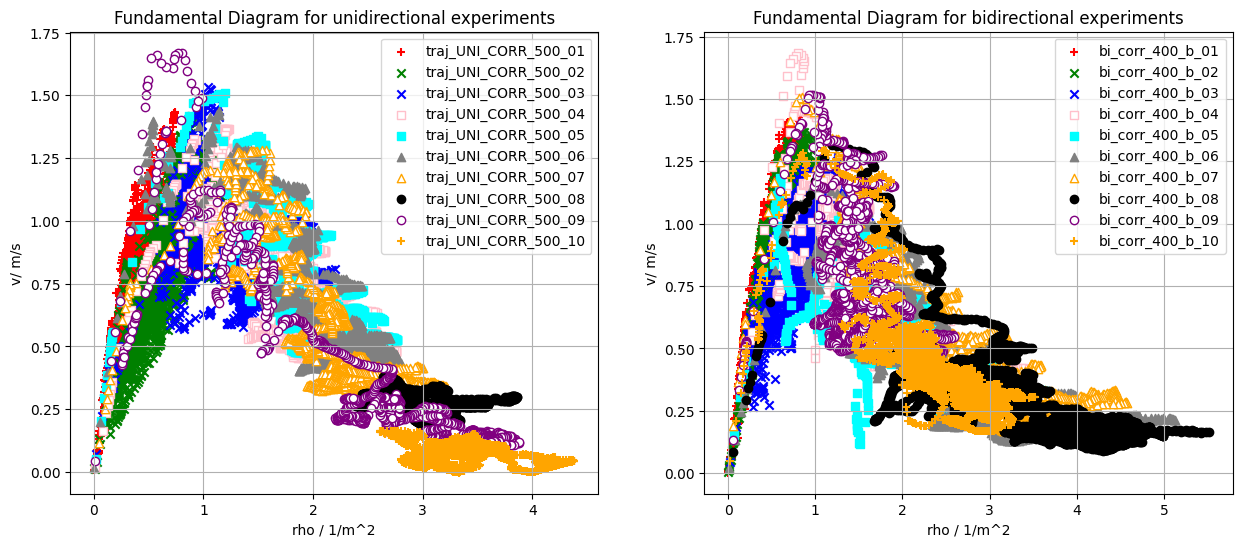

In [23]:
from pedpy.column_identifier import DENSITY_COL, SPEED_COL

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for name in sorted(line_densities_uni.keys()):
    ax1.scatter(
        line_densities_uni[name][DENSITY_COL],
        line_speeds_uni[name][SPEED_COL],
        alpha=1,
        label=name,
        **style_options[name],
    )

for name in sorted(line_densities_bi.keys()):
    ax2.scatter(
        line_densities_bi[name][DENSITY_COL],
        line_speeds_bi[name][SPEED_COL],
        alpha=1,
        label=name,
        **style_options[name],
    )

ax1.set_xlabel("rho / 1/m^2")
ax2.set_xlabel("rho / 1/m^2")
ax1.set_ylabel("v/ m/s")
ax2.set_ylabel("v/ m/s")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Fundamental Diagram for unidirectional experiments")
ax2.set_title("Fundamental Diagram for bidirectional experiments")
ax1.legend()
ax2.legend()
plt.show()